In [1]:
from qumin.representations import segments, patterns
import qumin.representations as qm
import pandas as pd
from utils import generate_with_prob, TweetExtractor
import seaborn as sns
# You need a private.py file which defines these variables.
from private import CONSUMER_KEY, ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET, CONSUMER_SECRET
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Predictive modelling

In this section, we try to predict potential forms for the past of "to tweet", based on analogical rules we compute from pairs of present and past verbs.


We first read the data (and create some new data for the verb "to tweet") for sounds and verbs

In [2]:
qm.segments.Inventory.initialize("data/en_sounds.csv", sep=",")
paradigms = qm.create_paradigms("data/en_verbs.csv",
                             long=False,
                             defective=True,
                             overabundant=True,
                             segcheck=False)
tweet = (qm.segments.Form("twiːt"), )
past_tweet = (segments.Form("twiːtɪd"), segments.Form("twəˑʊt"))
tweet_paradigm = pd.DataFrame.from_dict({"tweet": [tweet, past_tweet]}).T
tweet_paradigm.columns = paradigms.columns


We find analogical rules (patterns) that hold in the known verbs between the present and the past:

In [3]:
pats, pat_dic = patterns.find_patterns(paradigms, "similarity")

/home/sacha/anaconda3/envs/twitter/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



We can now have a look at all of the rules we found. Rules look like phonological rules, and follow the structure: ` <change> / <context>`, where:

- *change*: What changes between the present and the past. This is a pair of phonological material in the present (left) and the past (right), separated by `⇌`. If there are changes at multiple locations in the word, they are separated by "_".
- *context*: Provides restrictions on rule application and determines the location of the change(s). X means "anything". The context can contain featural descriptions such as `[-syll]` (any non syllabic sound) or sets of sounds such as `{k,p,t}`.

For example the rule `⇌ d / X+_` means "Add -d at the end of the word".


In [4]:
print(f"Found {len(pat_dic[('pres1s', 'past13')])} patterns")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    print(pats.iloc[:,0]
          .apply(lambda x: None if len(x.collection) != 1 else str(x.collection[0]))
          .sample(frac=1).drop_duplicates("last").dropna())



Found 59 patterns
lexeme
strike                                                             aˑɪ ⇌ ʌ / str_k
slay                                                                eˑɪ ⇌ uː / sl_
fight                                                        aˑɪ ⇌ ɔː / [-lab]*f_t
may                                                                eˑɪ ⇌ aˑɪt / m_
behold                                                            əˑʊ ⇌ ɛ / X*h_ld
will(aux)                                                             ɪl ⇌ ʊd / w_
have                                                                   v ⇌ d / hæ_
seek                                                                iːk ⇌ ɔːt / s_
can(modal)                                                            æn ⇌ ʊd / k_
leave                                                               iːv ⇌ ɛft / l_
choose                                                             uː ⇌ əˑʊ / tʃ_z
lose                                                          

We now check which of rules could be used on each verb: those are the applicable patterns. We search them for both the known verbs and our tweet present form.

In [5]:
classes = qm.patterns.find_applicable(paradigms, pat_dic, categorical=False).iloc[:,0]
usable_patterns = qm.patterns.find_applicable(tweet_paradigm, pat_dic, categorical=False).iloc[0,0]

Looking at only patterns that are susceptible to apply to tweet, we find the following possibilities (given with examples). The counts and probabilities in the below table are taken from the entire set of verbs: this is not ideal, because we know that analogy usually relies on phonological similarity. By ignoring phonological similarity, we are using rules that make very little sense.

In [6]:
display(generate_with_prob(tweet,
                        usable_patterns,
                        pats.iloc[:,0],
                        *("pres1s", "past13")))

generated         P  count  \
4    t w iː t d   0.502807   2956   
0  t w iː t ɪ d   0.282191   1659   
3    t w iː t t   0.193570   1138   
5      t w iː t   0.016840     99   
2     t w ɛ t t   0.001871     11   
1       t w ɛ t   0.001361      8   
6     t w əˑʊ t   0.001361      8   

                                            examples  \
4  abandon, abhor, abjure, abridge, absolve, abso...   
0  abate, abbreviate, abdicate, abduct, abet, abn...   
3  French-polish, abase, abash, abolish, about-fa...   
5  alight, beat, bend, beset, bestrew, bind, blee...   
2  creep, deal, feel, keep, kneel, mean, misdeal,...   
1  lead, mislead, speed, bottle-feed, force-feed,...   
6  bespeak, deep-freeze, freeze, quick-freeze, sp...   

                                  pattern  
4                               ⇌ d / X+_  
0              ⇌ ɪd / X*{d,k,t,ɡ}_[-lab]*  
3                       ⇌ t / X+[-voice]_  
5                                 ⇌  / X*  
2  iː_ ⇌ ɛ_t / X*[-syll]_{b,d,l,m,n,p,t}_  
1                       iː ⇌ ɛ / X*_{d,t}  
6                  iː ⇌ əˑʊ / X*[-syll]_C

Thus, it is more useful to restrict ourselves to similar words. Here, we do what is usually done in Qumin: compute probabilities on the basis on only the phonologically similar words. Our trick to find phonologically similar words in a way that is relevant to morphology is to pick only those words that have the exact same set of applicable patterns as *tweet*:

In [7]:

with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):

    sim = classes.loc[classes ==usable_patterns].index
    similar_words = pats.iloc[:,0].loc[sim]
    display(generate_with_prob(tweet, 
                        usable_patterns,
                        similar_words,
                        *("pres1s", "past13")))

generated         P  count  \
0  t w iː t ɪ d   0.861111     31   
1       t w ɛ t   0.055556      2   
5      t w iː t   0.055556      2   
6     t w əˑʊ t   0.027778      1   

                                                                                                                                                                                                                                                               examples  \
0  accrete, bleat, cheat, compete, complete, concrete, defeat, delete, deplete, entreat, excrete, fleet, greet, heat, ill-treat, maltreat, mete out, over-heat, pleat, preheat, receipt, repeat, reseat, retreat, seat, secrete, sleet, steam-heat, treat, unseat, yeet   
1                                                                                                                                                                                                                                                        over-eat, meet   
5                                                                                                                                                                                                                                                        beat, browbeat   
6                                                                                                                                                                                                                                                                  yeet   

                       pattern  
0   ⇌ ɪd / X*{d,k,t,ɡ}_[-lab]*  
1            iː ⇌ ɛ / X*_{d,t}  
5                      ⇌  / X*  
6       iː ⇌ əˑʊ / X*[-syll]_C

# Usage

We turn to twitter data, using a custom class to do our searching and annotation:

In [8]:
tweet_tool = TweetExtractor(consumer_key=CONSUMER_KEY,
                  consumer_secret=CONSUMER_SECRET,
                  access_token_key=ACCESS_TOKEN_KEY,
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  tweet_mode='extended',
                  sleep_on_rate_limit=True)

We search tweets corresponding to the query, then annotate rows depending on which word was used, and whether it was a mention or usage. We "explode" the result on keywords to obtain one row by keyword even when a tweet contains multiple keywords:

In [9]:
verbs = ["twote", "twitted", "tweeted"]
tweet_tool.search_twitter(" OR ".join([f"\"{v}\"" for v in verbs]), verbs)

Oldest: Fri Aug 26 02:48:09 +0000 2022: : 2692it [3:33:08,  4.75s/it] 


We shape the results into a table:

In [10]:
tweets = pd.DataFrame(tweet_tool.tweets).drop_duplicates()

In [11]:
tweets

id                            date  \
0       1563863622266519552  Sun Aug 28 12:18:37 +0000 2022   
1       1563171280421277702  Fri Aug 26 14:27:30 +0000 2022   
2       1565077763849068546  Wed Aug 31 20:43:11 +0000 2022   
3       1564056747043540992  Mon Aug 29 01:06:01 +0000 2022   
4       1564739380052475904  Tue Aug 30 22:18:34 +0000 2022   
...                     ...                             ...   
187490  1564114145250709505  Mon Aug 29 04:54:06 +0000 2022   
187491  1564739710781722624  Tue Aug 30 22:19:53 +0000 2022   
187492  1563526766890627074  Sat Aug 27 14:00:04 +0000 2022   
187493  1564764290846003201  Tue Aug 30 23:57:33 +0000 2022   
187494  1564750314057928704  Tue Aug 30 23:02:01 +0000 2022   

                                                     text   kind keywords  
0       RT @Kingshetty45: 4.3M💥💥💥\nPresenting you the ...  usage  tweeted  
1       RT @fuzzymittens: Twitter is now only showing ...  usage  tweeted  
2       RT @Esqueer_: I literally tweeted this earlier...  usage  tweeted  
3       RT @davidhogg111: @WhiteHouse @briebriejoy Who...  usage  tweeted  
4       RT @aCarrot__: They seriously all sat and said...  usage  tweeted  
...                                                   ...    ...      ...  
187490  RT @nisaaaaBTS: How is it not sus when other m...  usage  tweeted  
187491  RT @siiddartha: I’m sorry but whoever twote ab...  usage    twote  
187492  RT @AudreLawdAMercy: Literally tweeted out 'if...  usage  tweeted  
187493  which one of you guys tweeted this😭😭😭 https://...  usage  tweeted  
187494  @ravenwizardd @RapSheet @MikeGarafolo I'm find...  usage  tweeted  

[187495 rows x 5 columns]

26th -- 3rd, 269 200 tweets, kept 187 495

Here are the raw counts for each possibility. The usage of "twitted" is so low, it can probably be excluded as an infrequent typo.

In [14]:
tweets.keywords.value_counts()

tweeted            181989
twote                4769
twitted               714
tweeted+twote          19
tweeted+twitted         4
Name: keywords, dtype: int64

We plot a comparison of the two words frequency:

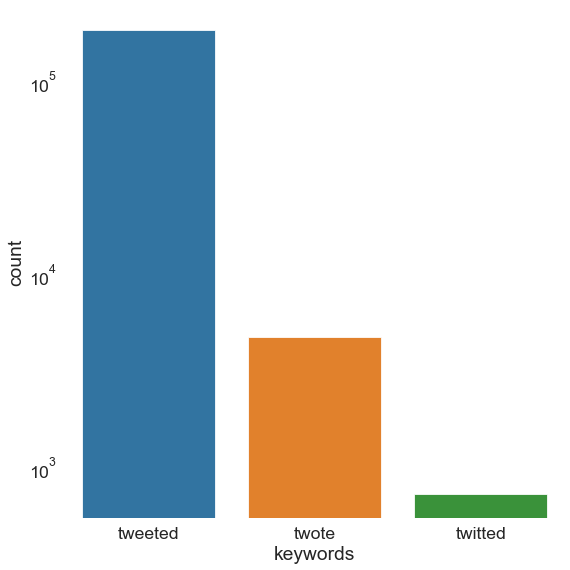

In [17]:
%matplotlib
%pylab inline
from matplotlib import pyplot as plt
sns.set_context("paper", font_scale=2)

g = sns.catplot(x="keywords", kind="count", data=tweets[(tweets.kind=="usage") & (tweets.keywords != "twitted")],  height=8)

plt.gcf().savefig("ranking_2V.png")

Finally, a comparison of mentions, showing that "twote" is probably more controversial:

/home/sacha/anaconda3/envs/twitter/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


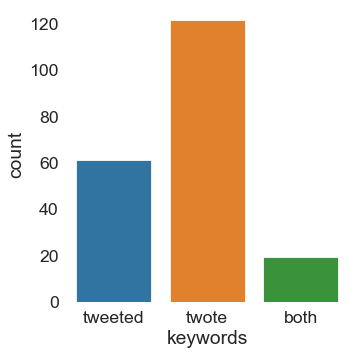

In [45]:
mentions = tweets[( tweets.kind=="mention") & (~tweets.keywords.str.contains("twitted"))]
mentions.keywords = mentions.keywords.replace("tweeted+twote", "both")
g = sns.catplot(x="keywords", kind="count", data=mentions)